In [1]:
from matplotlib_venn import venn2
import pickle
import pandas as pd

from pathlib import Path
from datetime import datetime


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.figure as figure


rc = {"figure.dpi": 150}
sns.set_theme(
    context="notebook",
    style="white",
    palette="deep",
    font="sans-serif",
    font_scale=1.2,
    color_codes=True,
    rc=rc,
)

In [2]:
p = Path().cwd().parent
date = datetime.today().strftime("%Y%m%d")[2:]  # Get shortened year

path_out = p / f"{date}_output"
path_out.mkdir(parents=True, exist_ok=True)


def save_fig(fig_name, tight_layout=True, fig_extension="png", resolution=300):
    """Save figure in png."""
    path = path_out / f"{fig_name}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
file_path = p / "250314_output" / "list_of_gene_name_set_1000"
with open(file_path, "rb") as f:
    list_of_gene_name_sets = pickle.load(f)

In [4]:
len(list_of_gene_name_sets)

1000

In [5]:
from collections import Counter

gene_list_unpacked = []
for gene_set in list_of_gene_name_sets:
    for gene in gene_set:
        gene_list_unpacked.append(gene)


cnt_gene = Counter()
for gene in gene_list_unpacked:
    cnt_gene[gene] += 1

print(cnt_gene.total())

fs_genes = set(gene_list_unpacked)
fs_genes_top = set(
    [gene for gene, count in cnt_gene.most_common(int(0.2 * len(cnt_gene)))]
)

249996


In [6]:
de_genes_file_path = p / "250314_output" / "de_genes.txt"
with open(de_genes_file_path, "r") as file:
    de_genes = file.read().splitlines()
de_genes = set(de_genes)

In [7]:
cnt_gene_df = pd.DataFrame.from_dict(cnt_gene, orient="index", columns=["Count"])
cnt_gene_df.reset_index(inplace=True)
cnt_gene_df.rename(columns={"index": "Gene"}, inplace=True)
cnt_gene_df.sort_values(by="Count", ascending=False, inplace=True)
cnt_gene_df["Differentially Expressed"] = cnt_gene_df["Gene"].apply(
    lambda x: x in de_genes
)
cnt_gene_df.to_csv(path_out / f"feature_selection_genes.csv", index=False)
print(cnt_gene_df)

         Gene  Count  Differentially Expressed
134      MPP1   1000                     False
201     CSF1R   1000                      True
204       ENG   1000                      True
198     CXCL2   1000                      True
55     TNFSF8   1000                     False
...       ...    ...                       ...
1016    HDAC7      1                     False
1015     SRGN      1                     False
1007    CIRBP      1                     False
934    MYCBP2      1                     False
1061  EHBP1L1      1                     False

[1062 rows x 3 columns]


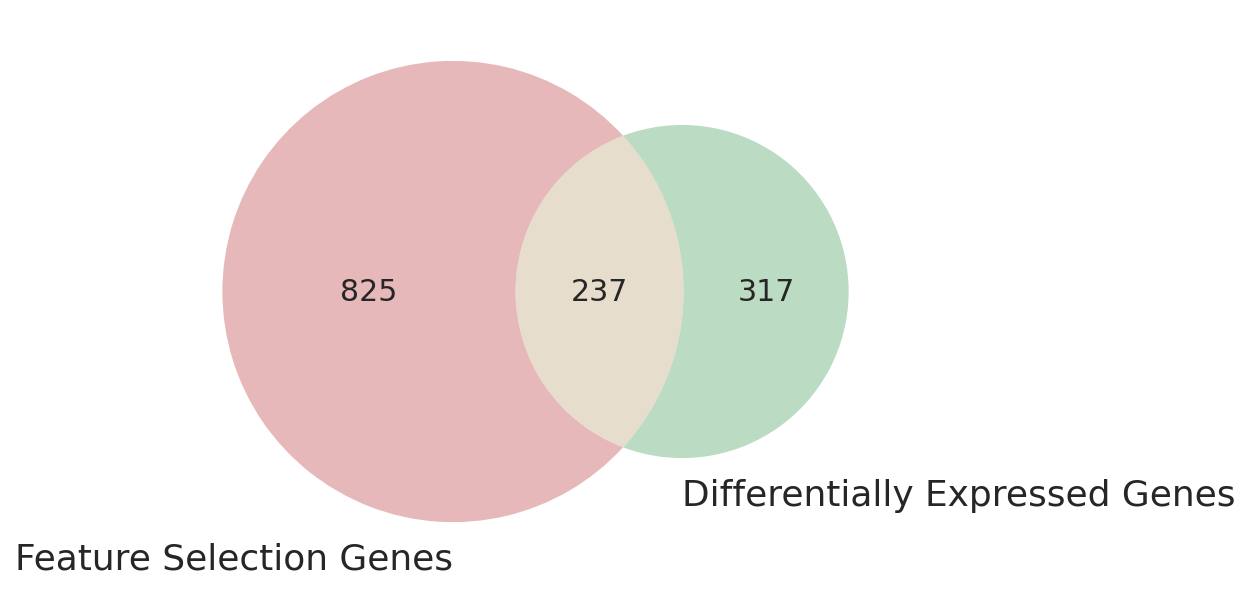

In [8]:
v = venn2(
    (fs_genes, de_genes),
    set_labels=("Feature Selection Genes", "Differentially Expressed Genes"),
)

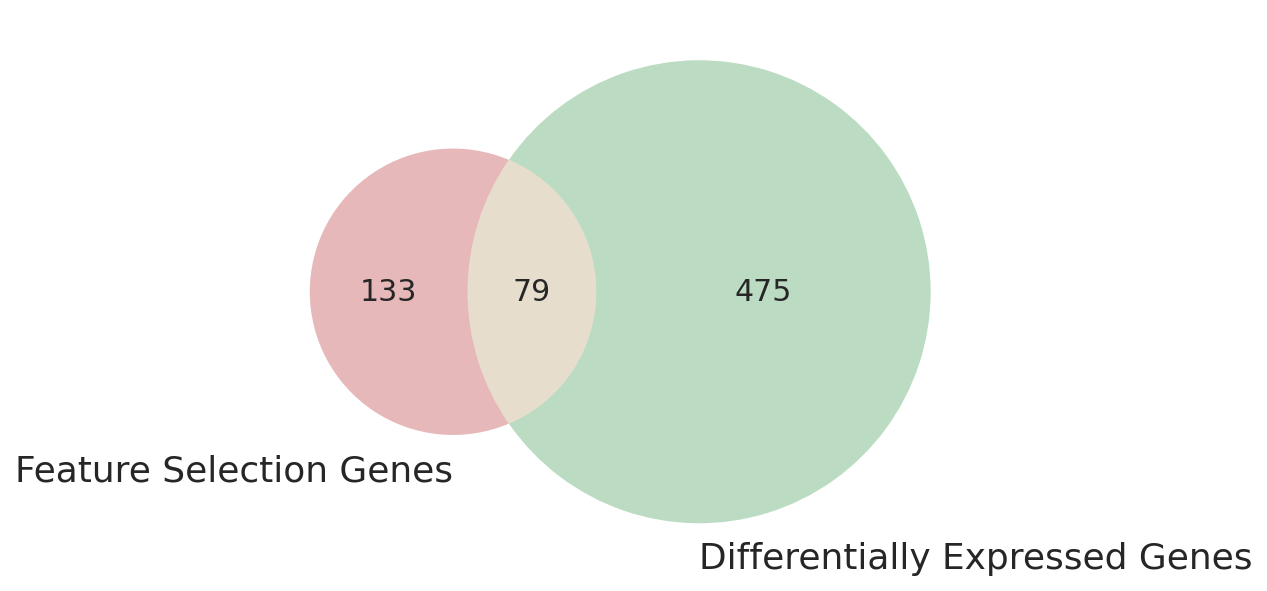

In [9]:
v = venn2(
    (fs_genes_top, de_genes),
    set_labels=("Feature Selection Genes", "Differentially Expressed Genes"),
)

In [10]:
fs_not_in_de = fs_genes - de_genes

In [11]:
import os
import pandas as pd
import scanpy as sc
import anndata
import pickle

from goatools.base import download_go_basic_obo
from goatools.base import gunzip
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

import sys

sys.path.insert(1, "/home/t.afanasyeva/MAT_rnaseq/notebooks/DeSeq2/")
from genes_ncbi_homo_sapiens_proteincoding import GENEID2NT as GeneID2nt_hs

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference

from pathlib import Path
from datetime import datetime

from adjustText import adjust_text
from typing import Union
from anndata import AnnData
import seaborn as sns
import textwrap
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.figure as figure
from matplotlib.patches import Patch
from DeSeq2.genes_ncbi_homo_sapiens_proteincoding import GENEID2NT as GeneID2nt_hs

rc = {"figure.dpi": 150}
sns.set_theme(
    context="notebook",
    style="white",
    palette="deep",
    font="sans-serif",
    font_scale=1.2,
    color_codes=True,
    rc=rc,
)

/home/t.afanasyeva/miniforge3/envs/PYDESEQ2/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/t.afanasyeva/miniforge3/envs/PYDESEQ2/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/t.afanasyeva/miniforge3/envs/PYDESEQ2/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/t.afanasyeva/miniforge3/envs/PYDESEQ2/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/home/t.afanasyeva/miniforge3/envs/PYDESEQ2/lib/python3.11/site-packag

In [12]:
from pathlib import Path
from datetime import datetime

p = Path().cwd().parent
date = datetime.today().strftime("%Y%m%d")[2:]  # Get shortened year

path_out = p / f"{date}_output"
path_out.mkdir(parents=True, exist_ok=True)


def save_fig(fig_name, tight_layout=True, fig_extension="png", resolution=300):
    """Save figure in png."""
    path = path_out / f"{fig_name}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [13]:
p = Path().cwd().parent.parent
date = datetime.today().strftime("%Y%m%d")[2:]  # Get shortened year
RESULTS_PATH = p / f"{date}_output"
RESULTS_PATH.mkdir(parents=True, exist_ok=True)


def save_csv(table, table_name):
    """Save table in csv."""
    path = RESULTS_PATH / f"{table_name}.csv"
    table.to_csv(path)

In [14]:
class Plotter:
    geneid_symbol_mapper_human = None
    goeaobj = None
    total_go_terms = None
    is_initialized = False

    def __init__(
        self,
        sigs: pd.DataFrame,
        analysis_name: str,
    ):
        self.sigs = sigs
        self.analysis_name = analysis_name

        if not Plotter.is_initialized:
            Plotter._initialise_go()
            Plotter.is_initialized = True

    def make_figure(self, plot_type: str):

        if plot_type not in ["volcano", "histogram", "pca", "go"]:
            raise ValueError(
                "plot() takes 'volcano', 'histogram', 'pca' or 'go' as a condition."
            )

        fig_extension = "png"
        fname = RESULTS_PATH / f"{self.analysis_name}_{plot_type}.{fig_extension}"
        fontsize = 12

        if plot_type == "volcano":
            fig = self.plot_volcano()
            plt.title(
                f"{self.analysis_name} Differentially Expressed Genes",
                fontsize=fontsize,
                fontweight="bold",
            )

        if plot_type == "histogram":
            fig = self.plot_historgram()
            fig.ax_col_dendrogram.set_title(
                f"{self.analysis_name} Differentially Expressed Genes",
                fontsize=fontsize,
                fontweight="bold",
                pad=2,
            )
        if plot_type == "pca":
            fig = self.plot_pca()
            fig.axes[0].set_title(
                f"{self.analysis_name}", fontsize=fontsize, fontweight="bold"
            )

        if plot_type == "go":
            fig = self.plot_go()
            plt.title(
                f"{self.analysis_name} Top 20 Significant GO Terms",
                fontsize=fontsize,
                fontweight="bold",
            )

            go_df = self.generate_go_table()
            save_csv(go_df, f"{self.analysis_name}_go_terms")

        fig.figure.savefig(
            fname,
            format=fig_extension,
            dpi=300,
            bbox_inches="tight",
        )

    @classmethod
    def _initialise_go(cls):
        """Get GO terms and initiate gotools classes."""
        print("Initializing GO terms...")

        path_to_supporting_files = Path().cwd() / "DeSeq2/deseq2"

        """
            download_ncbi_associations() needed for gene2go returned critical connection error, 
            likely was not handled well by Sanquin's firewall. 
            I have downloaded the gene2go data from 
            ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz on 27-02-2025 and unzipped.
            """
        # gunzip(path_to_supporting_files / "gene2go.gz")
        genes = Gene2GoReader(
            path_to_supporting_files / "gene2go", taxids=[9606], namespaces={"BP"}
        )
        ns2assoc = genes.get_ns2assc()

        """Downloaded ontologies on 27-02-2025"""
        # obo_fname = download_go_basic_obo() # saves them to the same folder as this script
        obodag = GODag(path_to_supporting_files / "go-basic.obo")

        cls.goeaobj = GOEnrichmentStudyNS(
            GeneID2nt_hs.keys(),  # List of human protein-coding genes
            ns2assoc,  # Geneid/GO associations
            obodag,  # Ontologies
            propagate_counts=False,
            alpha=0.05,  # Default significance cut-off
            methods=["fdr_bh"],  # Default correction method for multiple testing
        )

        cls.geneid_symbol_mapper_human = {
            GeneID2nt_hs[key].Symbol: GeneID2nt_hs[key].GeneID for key in GeneID2nt_hs
        }

    def generate_go_table(self):
        """Retrieve GO terms per condition"""
        sigs_ids = [
            Plotter.geneid_symbol_mapper_human[gene]
            for gene in self.sigs
            if gene in Plotter.geneid_symbol_mapper_human
        ]
        print(
            f"Mapped {len(sigs_ids)/len(self.sigs)*100:.2f}% of",
            "GeneIDs of significantly differentially expressed genes symbols to gene IDs.",
        )

        goea_results = Plotter.goeaobj.run_study(sigs_ids, prt=None)
        goea_results_sig = [r for r in goea_results if r.p_fdr_bh < 0.05]

        inverted_mapping_dictionary = {
            v: k for k, v in Plotter.geneid_symbol_mapper_human.items()
        }  # Map study item IDs to gene symbols

        go_df = pd.DataFrame(
            list(
                map(
                    lambda x: [
                        x.GO,
                        x.goterm.name,
                        x.goterm.namespace,
                        x.p_uncorrected,
                        x.p_fdr_bh,
                        x.ratio_in_study[0],
                        x.ratio_in_study[1],
                        x.ratio_in_study[0] / x.ratio_in_study[1],
                        list(
                            map(lambda y: inverted_mapping_dictionary[y], x.study_items)
                        ),
                    ],
                    goea_results_sig,
                )
            ),
            columns=[
                "GO",
                "term",
                "class",
                "raw_pvalue",
                "fdr",
                "n_genes",
                "n_study",
                "ratio_in_study",
                "gene_symbols",
            ],
        )
        go_df["gene_symbols"] = go_df["gene_symbols"].apply(lambda x: ", ".join(x))
        go_df = go_df.sort_values("fdr", ascending=True)
        return go_df

    def plot_go(self):
        """Plot Go terms."""
        go_terms = self.generate_go_table()

        go_terms = go_terms[:20]
        go_terms = go_terms.sort_values("ratio_in_study", ascending=False)

        norm = mpl.colors.Normalize(vmin=go_terms.fdr.min(), vmax=go_terms.fdr.max())
        color_mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.bwr_r)
        rc = {"axes.edgecolor": "black"}
        sns.set_theme(rc=rc)

        g = plt.figure(figsize=(8, 10))

        ax = sns.barplot(
            data=go_terms,
            x=go_terms["n_genes"] / go_terms["n_study"],
            y="term",
            palette=list(color_mapper.to_rgba(go_terms.fdr.values)),
        )

        ax.set_yticklabels([textwrap.fill(term, 40) for term in go_terms["term"]])
        cbar = g.colorbar(
            color_mapper, ax=ax, orientation="vertical", pad=0.01, format="{x:.4f}"
        )
        cbar.ax.set_position([0.8, 0.5, 0.2, 0.3])
        cbar.ax.set_title("padj", loc="left", pad=4.0)

        return g

Initializing GO terms...
HMS:0:01:38.138409 157,436 annotations, 18,834 genes, 12,195 GOs, 1 taxids READ: /home/t.afanasyeva/MAT_rnaseq/notebooks/DeSeq2/deseq2/gene2go BP
/home/t.afanasyeva/MAT_rnaseq/notebooks/DeSeq2/deseq2/go-basic.obo: fmt(1.2) rel(2025-02-06) 43,597 Terms

Load BP Ontology Enrichment Analysis ...
 83% 17,077 of 20,615 population items found in association
Mapped 99.15% of GeneIDs of significantly differentially expressed genes symbols to gene IDs.
Mapped 99.15% of GeneIDs of significantly differentially expressed genes symbols to gene IDs.
Mapped 99.15% of GeneIDs of significantly differentially expressed genes symbols to gene IDs.


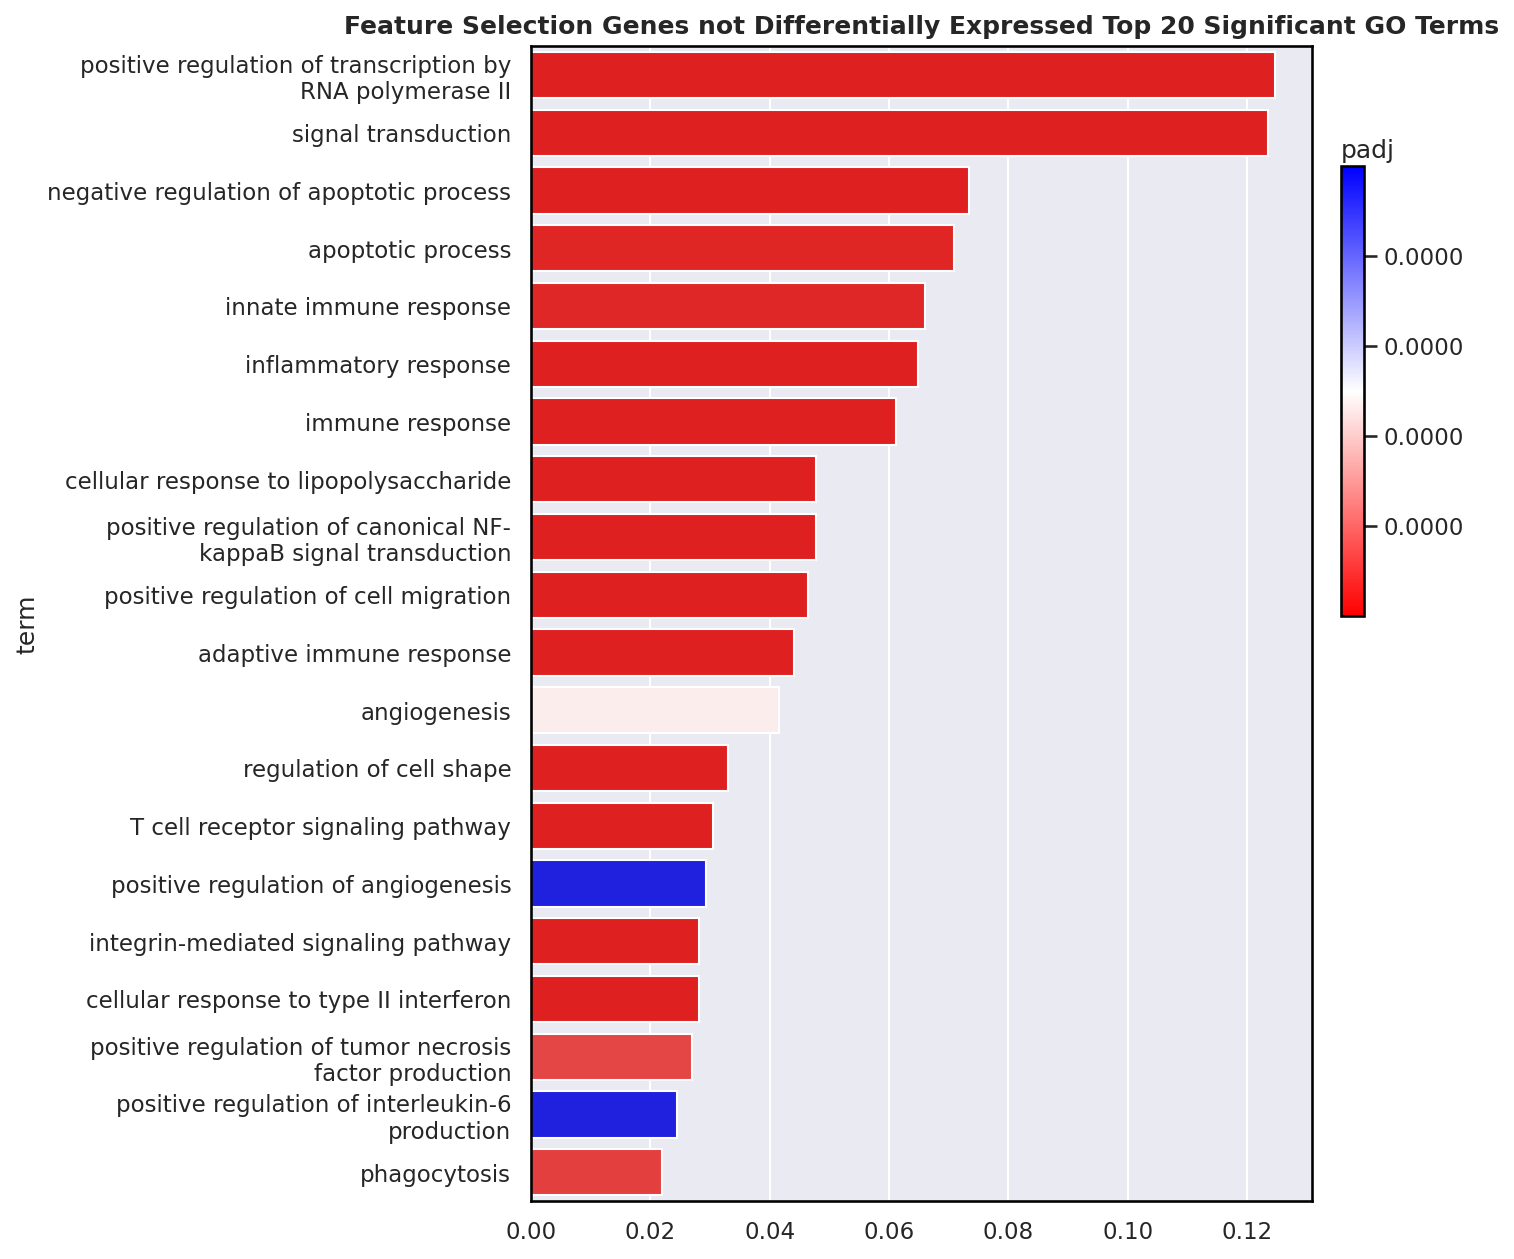

In [15]:
plotter = Plotter(fs_not_in_de, "Feature Selection Genes not Differentially Expressed")
df = plotter.generate_go_table()
df.to_csv(path_out / "GO_FS_not_DE.csv", index=False)
df.to_excel(path_out / "GO_FS_not_DE.xlsx", index=False)
plotter.make_figure("go")

Mapped 94.09% of GeneIDs of significantly differentially expressed genes symbols to gene IDs.
Mapped 94.09% of GeneIDs of significantly differentially expressed genes symbols to gene IDs.
Mapped 94.09% of GeneIDs of significantly differentially expressed genes symbols to gene IDs.


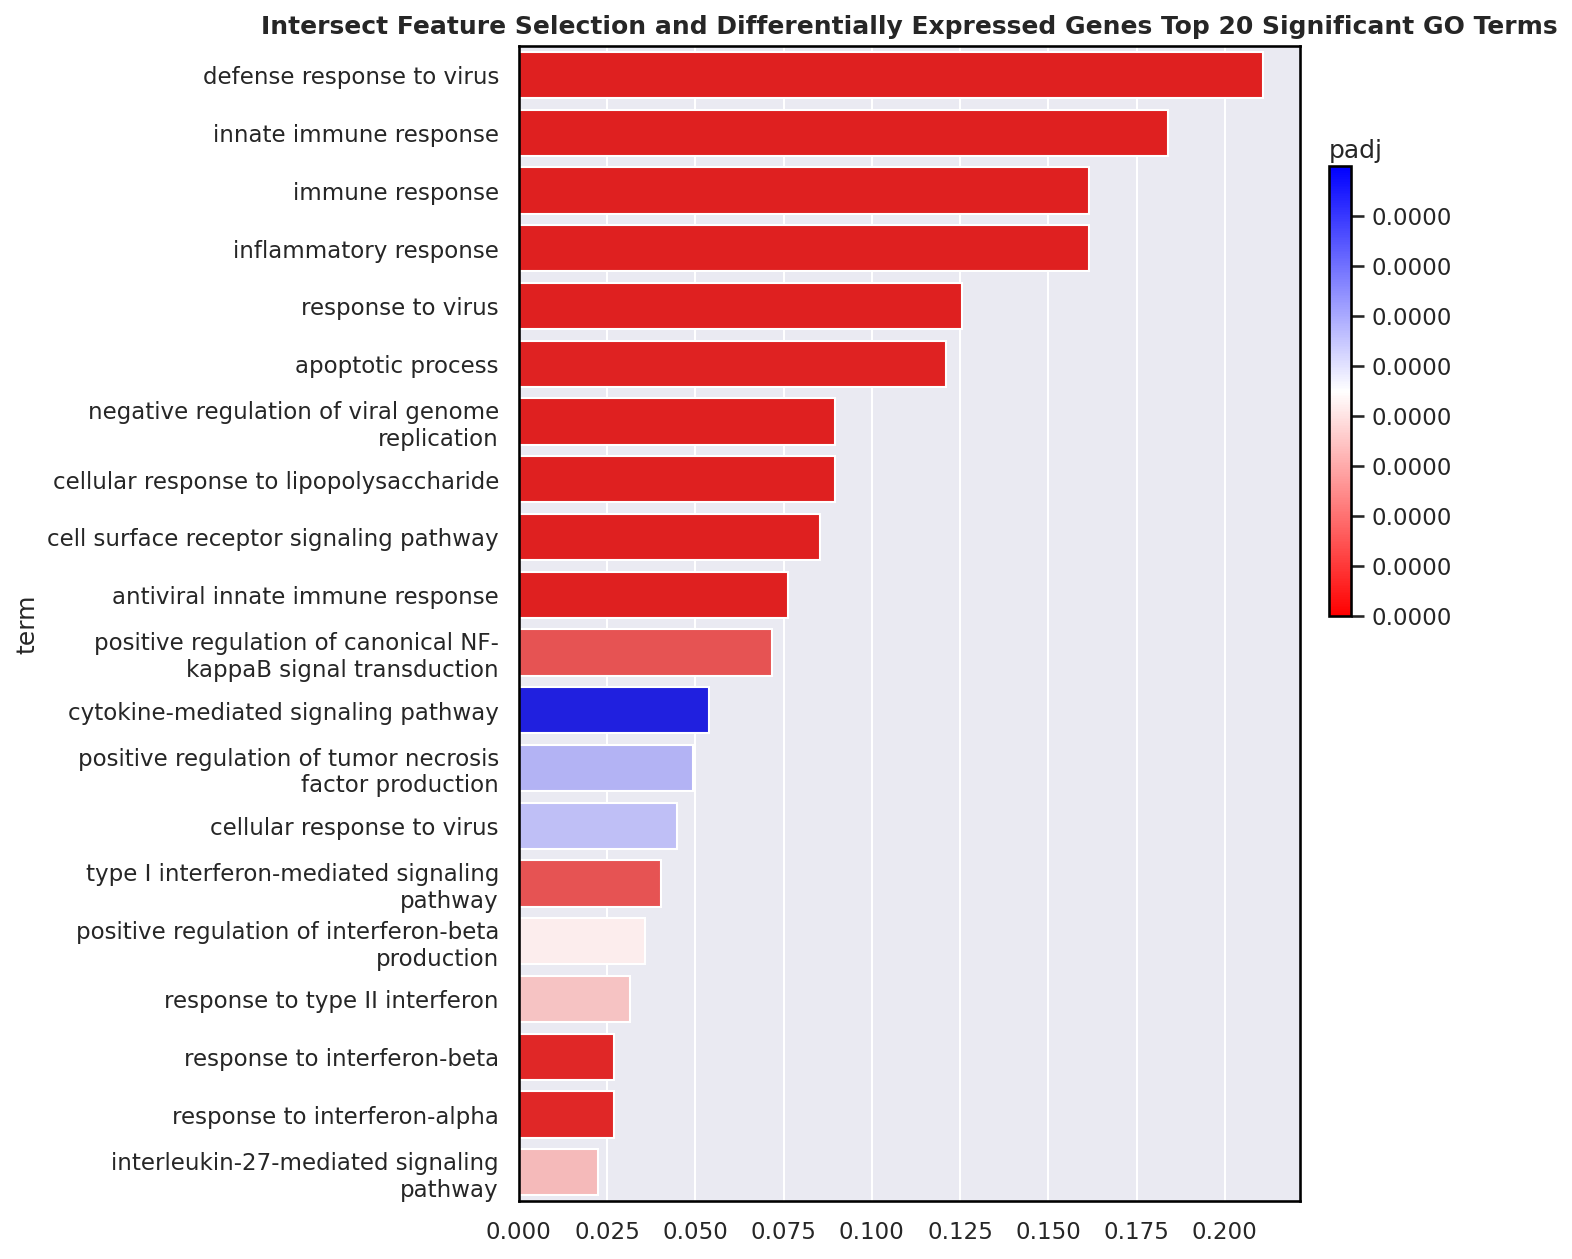

In [16]:
plotter_intersect = Plotter(
    fs_genes.intersection(de_genes),
    "Intersect Feature Selection and Differentially Expressed Genes",
)
df_intersect = plotter_intersect.generate_go_table()
df_intersect.to_csv(path_out / "GO_FS_and_DE.csv", index=False)
df_intersect.to_excel(path_out / "GO_FS_and_DE.xlsx", index=False)
plotter_intersect.make_figure("go")